# TD 6 - 26th of Jan. 2024

Faisal Jayousi: jayousi@unice.fr

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import norm

## Forward model: the blurring operator

In SMLM type data, the acquisition consist of a blurred and noisy image of a molecule sample (the ground truth image). 
Let $x\in\mathbb R^n$ be the ground truth image. The microscope's limitations only permit access to a blurred and noisy version $$y=Ax+\eta$$
where $A:\mathbb R^n \longrightarrow \mathbb R^n$ is the forward blurring operator and $\eta\in\mathbb R^n$ is a Gaussian distributed noisy vector with $0$ mean and variance $\sigma^2$: $\eta\sim\mathcal N(0,\sigma^2)$.

Given the acquisition $y$, we aim to reconstruct the ground truth $x$. To do so, a thorough understanding of the microscope's functioning is required, and a corresponding forward model must be proposed.

* Load the ground truth image.

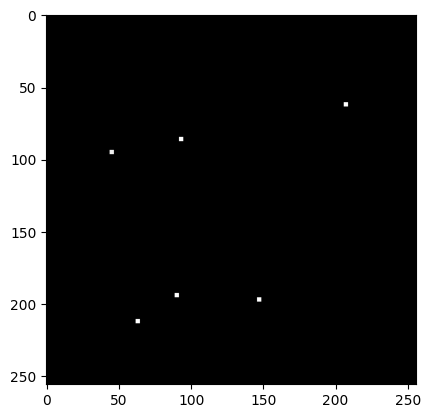

In [2]:
# load the image
gt = plt.imread('gt.png')
gt = gt[..., 1]
gt = gt * 255.

# plot the image
plt.imshow(gt, cmap='gray')
plt.show()
print()

We will now focus on the blurring operator. Recall that it is inconvenient (and often impossible) to construct the matrix $A$. Multiplying an image with a blurring matrix (huge) can be written as a convolution between the image itself and an appropriate kernel (that has the same size as the image), called Point Spread Function (PSF), since it describes how a point is distorted (and spread) by the microscope. To do so, the Fast Fourier Trasform is used and only the PSF has to be stored.

#### Dimensions



In [3]:
print("Dimension of the ground truth image has: " + str(np.shape(gt)[0]) + "*" + str(np.shape(gt)[0]))
print("Vector length: " + (str(np.shape(gt)[0] * np.shape(gt)[0])))
print("The dimension of matrix A: " + str((np.shape(gt)[0] * np.shape(gt)[0]) * (np.shape(gt)[0] * np.shape(gt)[0])) + 
     " Like we can observe, the dimensions of matrix A are huge")

Dimension of the ground truth image has: 256*256
Vector length: 65536
The dimension of matrix A: 4294967296 Like we can observe, the dimensions of matrix A are huge


* Let $\sigma_h=20$. Create the associated Gaussian kernel $h$.

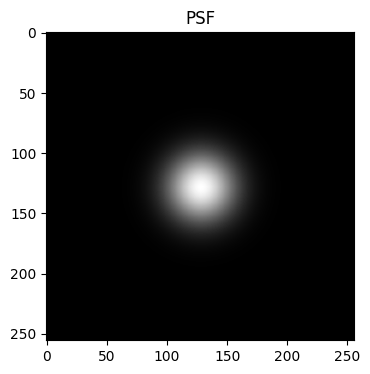

In [4]:
# convolution kernel: the point spread function PSF

s = 20
t = np.concatenate((np.arange(0, gt.shape[0]/2+1), np.arange(-gt.shape[0]/2,-1)))
Y, X = np.meshgrid(t,t)
h = np.exp(-(X**2+Y**2)/(2.0*float(s)**2))
h = h/np.sum(h)

plt.figure(figsize=(4, 4))
plt.imshow(np.fft.fftshift(h), cmap='gray')
plt.title('PSF')
plt.show()

In [5]:
# define the forward operator using the convolution theorem
def forward_operator(x, h):
    return np.real(np.fft.ifft2(np.fft.fft2(h)*np.fft.fft2(x)))
# should both of them be in the furious trasform

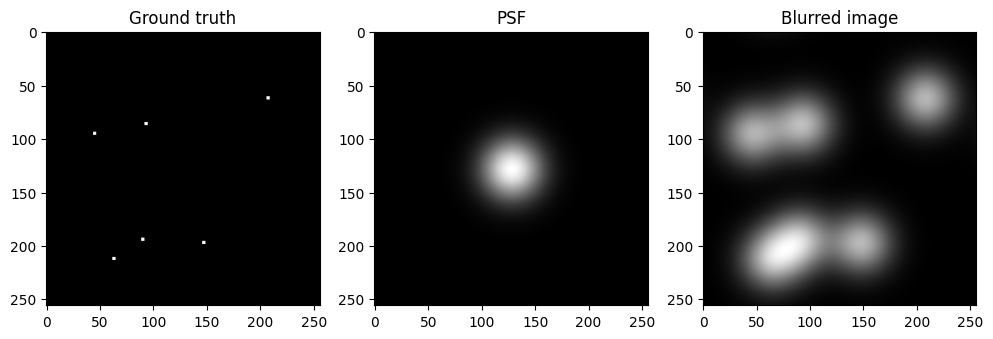

In [6]:
# compute the blurred imaage
blurred_image = forward_operator(gt, h)

# plot the ground truth, the PSF and the blurred image
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(gt, cmap='gray')
plt.title('Ground truth')
plt.subplot(132)
plt.imshow(np.fft.fftshift(h), cmap='gray')
plt.title('PSF')
plt.subplot(133)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred image')
plt.show()

Now we need to generate a noisy realisation of the blurred image in order to obtain a realistic acquisition. Add some Gaussian noise with $\sigma=0.1$.

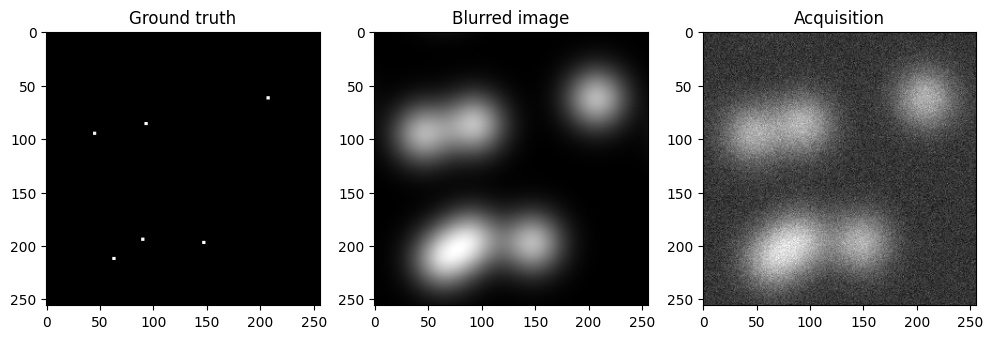

In [7]:
# in this way you will have a deterministic result
np.random.seed(24)

#generate a gaussian noise
sigma_noise = 0.1
noise = np.random.randn(*blurred_image.shape)

#blurred image with gaussian noise
acq = noise * sigma_noise + blurred_image

# plot the ground truth, the blurred image and the final acquisition (blurred and noisy)
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(gt, cmap='gray')
plt.title('Ground truth')
plt.subplot(132)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred image')
plt.subplot(133)
plt.imshow(acq, cmap='gray')
plt.title('Acquisition')
plt.show()

## Implementation of the Forward-Backward algorithm (ISTA)

Let $y\in\mathbb R^n$ be a noisy acquisition and $A:\mathbb R^n \longrightarrow \mathbb R^n$ the blurring operator. To solve the inverse problem i.e. to find $x\in\mathbb R^n$ such that $$y=Ax+\eta$$ We use a variational approach and solve
$$ \operatorname{argmin}_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|_2^2+\lambda \|x\|_1+\texttt{i}_{\ge 0}(x) $$
with the Forward-Backward algorithm. The first step of FB algorithm is the forward step: a gradient descent step for the smooth function $f$. 

Implement a function that computes the gradient of $f$, $\nabla f(x)= A^T (Ax-y)$.

In [8]:
# define the gradient of the fidelity term in terms of convolutions
def gradient(x, h, y):
    aus = forward_operator(x, h) - y
    return np.real(np.fft.ifft2(np.conj(np.fft.fft2(h)) * np.fft.fft2(aus)))
#real part (np.real())!

Compute now the Lipschitz constant of $\nabla f$, recalling that $L=\|A\|^2$. This will be needed for choosing a suitable stepsize.

In [9]:
# compute the Lipschitz constant Lips/ is the step size
hf = np.real(np.fft.fft2(np.fft.fftshift(h))) 
Lips = 1/np.max(hf**2)

Define the soft thresholding function below. This function is needed during the backward step.

In [10]:
# prox of \ell_1 norm: soft thresholding function
def soft_thresholding(x, gamma):
    return np.sign(x) * np.maximum(0, np.abs(x) - gamma)

Implement a function that computes the fidelity term $f(x)=\frac{1}{2}\|Ax-y\|_2^2$ and the cost function $F(x)=\frac{1}{2}\|Ax-y\|_2^2+\lambda \|x\|_1$  at each point.

In [11]:
# fidelity
def fidelity(x, h, y):
    return 0.5 * np.linalg.norm(forward_operator(x, h) - y)**2

# cost function
def cost_function(x, h, y, lmbda):
    return fidelity(x, h, y) + lmbda * np.linalg.norm(x, 1)

You have now the elements to define the function for the FB algorithm.

In [12]:
# input parameters
# x0 is the initialisation
# tau is the stepsize
# lambda is the regularisation parameter
# y is the acquisition, h is the psf ---> needed to compute the gradient of f at each iteration
# epsilon is the tolerance parameter, maxiter is the maximum numer of iterations ---> needed for the stopping criterion

def FB(x0, tau, lmbda, y, h, epsilon, maxiter):
    xk = x0
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)
    
    for k in np.arange(maxiter):

        if (k + 1) % 100 == 0:
            print(f'Iter {k+1}/{maxiter}')
        # forward step: gradient descent of f 
        xkk = xk - tau * gradient(xk, h, y)

        # backward step 
        xkk = soft_thresholding(xkk, tau*lmbda)
        
        # positivity constraints
        xkk = np.maximum(0, xkk)
        
        # compute the cost function
        cost[k] = cost_function(xkk, h, y, lmbda)
        norms[k] = np.linalg.norm(xkk-xk,'fro')
        
        # update the iteration
        xk = xkk
        if np.abs(cost[k] - cost[k-1]) / cost[k] < epsilon:
            break
    return xk , cost, norms

Useful: define a function to plot reconstruction, cost function and relative changes of the iterates.

In [13]:
def plot_results(rec, cost, norms):
    # plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(gt, cmap='gray')
    plt.title('Ground truth')
    plt.subplot(132)
    plt.imshow(acq, cmap='gray')
    plt.title('Acquisition')
    plt.subplot(133)
    plt.imshow(rec, cmap='gray')
    plt.title('Reconstruction')
    plt.show()

    # plot how the cost function decreases and how the iterates converge
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(cost)
    plt.xlabel('$k$')
    plt.ylabel("$F(x_k)$")
    plt.title('Cost function')
    plt.subplot(122)
    plt.plot(norms)
    plt.xlabel('$k$')
    plt.ylabel("$||x^{(k+1)}-x_{k}||$")
    plt.title('Relative difference in the reconstructions')
    plt.show()

Check that your algorithm is working by computing the reconstruction for the following set of input parameters.

Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


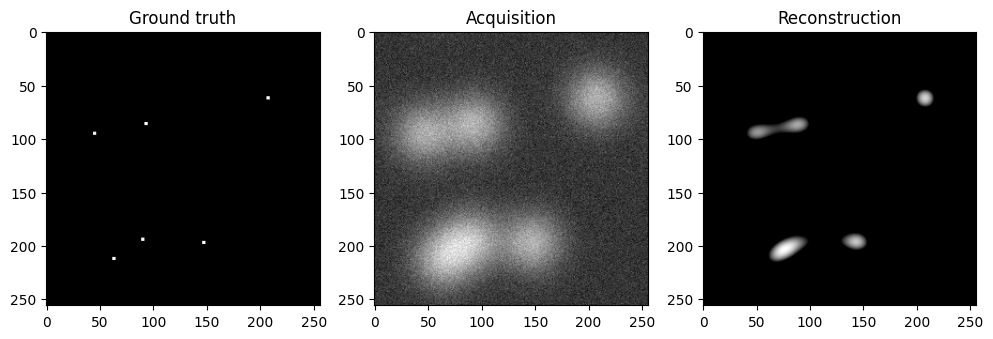

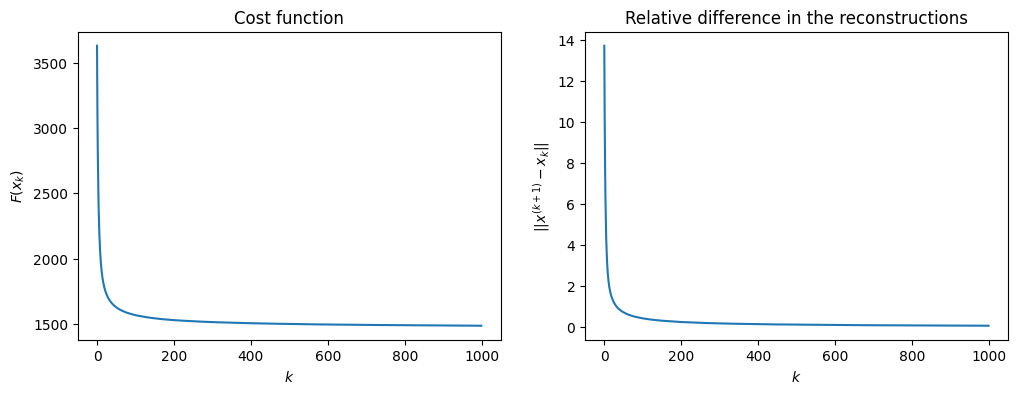

In [14]:
n = np.shape(gt)[0]
dim = (n, n)
x0 = np.zeros(dim)
tau = 0.5
lmbda = 0.3
maxiter = 1000
epsilon = 0.001


# compute the reconstruction
rec, cost, norms = FB(x0, tau, lmbda, acq, h, 0, maxiter)
plot_results(rec, cost, norms)

## Questions: regularisation parameter

1) Try different values of the regularisation parameter and see what happens. Can you explain the behaviour of the reconstructions with respect to $\lambda$? Does the choice of $\lambda$ affect the reconstruction?

\lambda=0.001
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


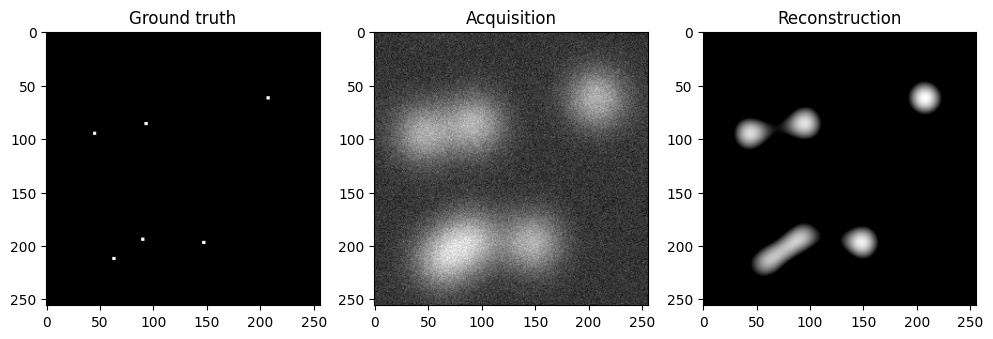

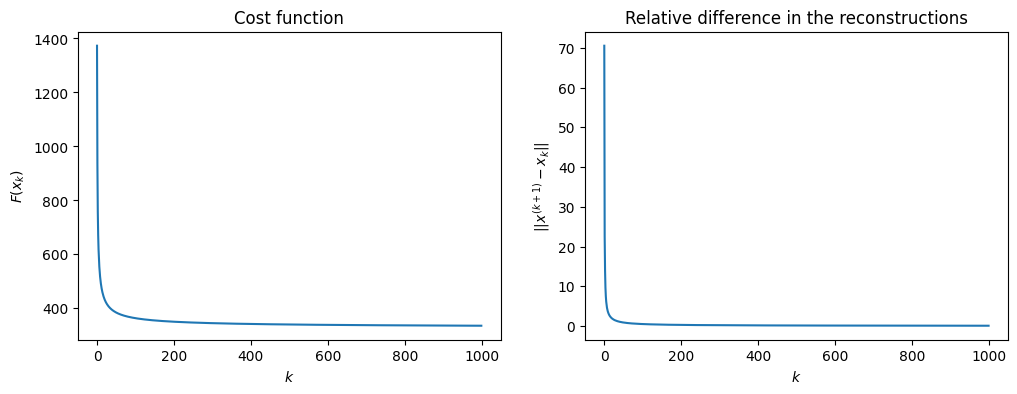

\lambda=0.1
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


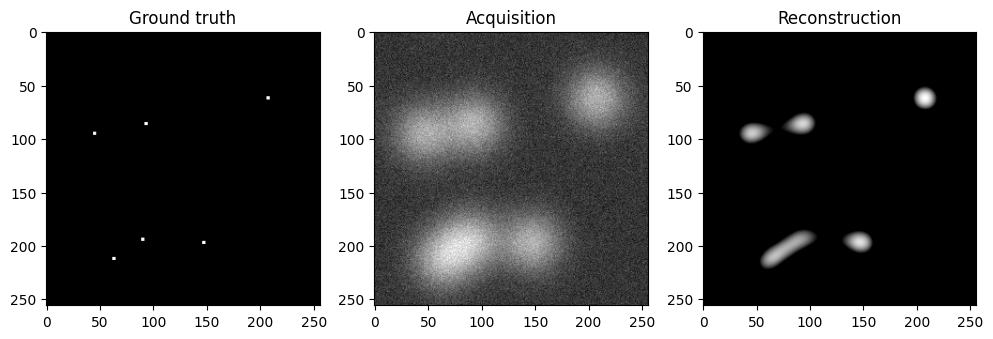

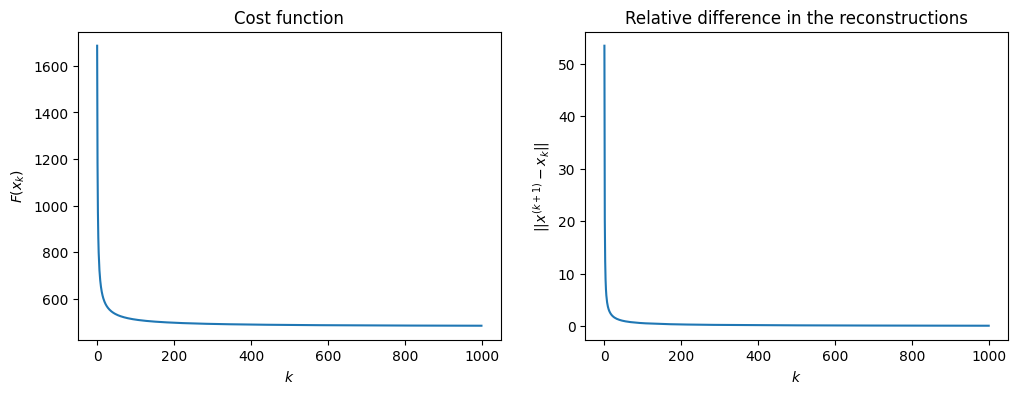

\lambda=0.2
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


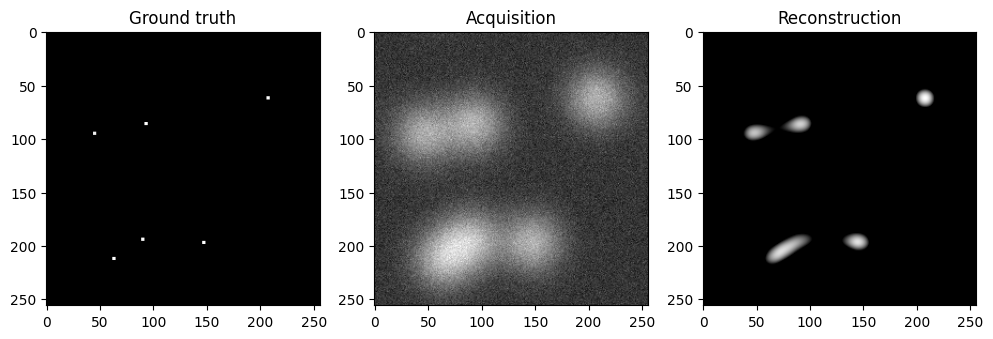

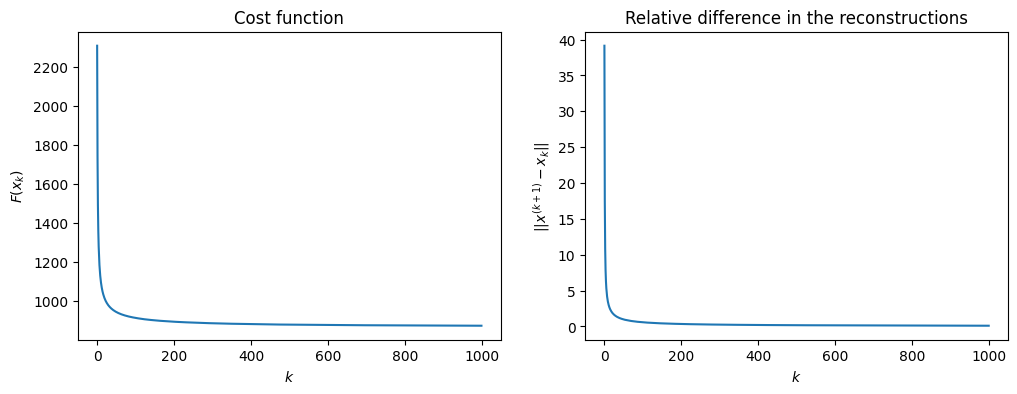

\lambda=0.3
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


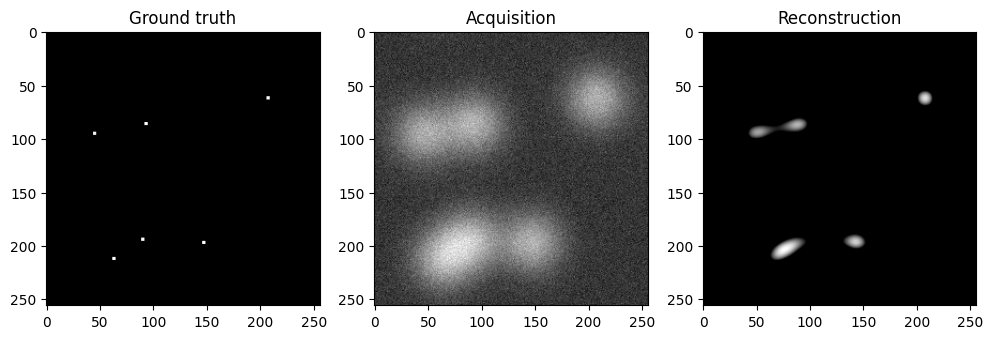

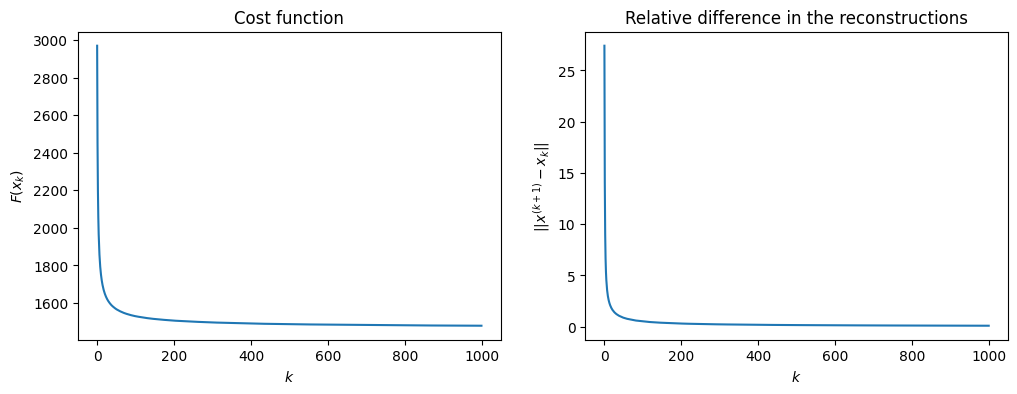

\lambda=0.4
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


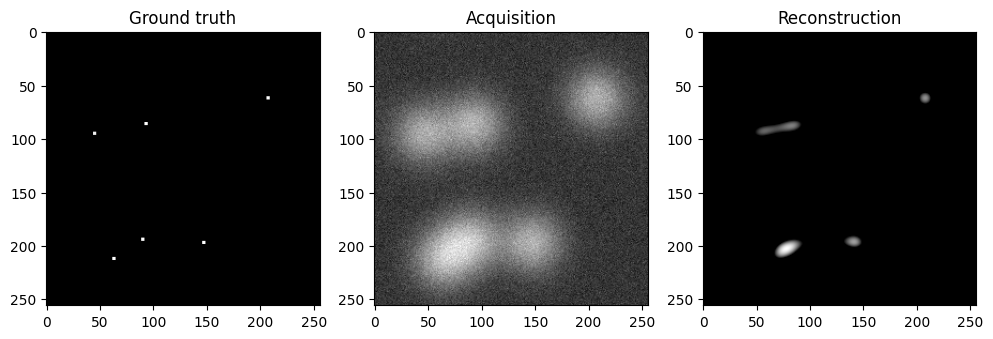

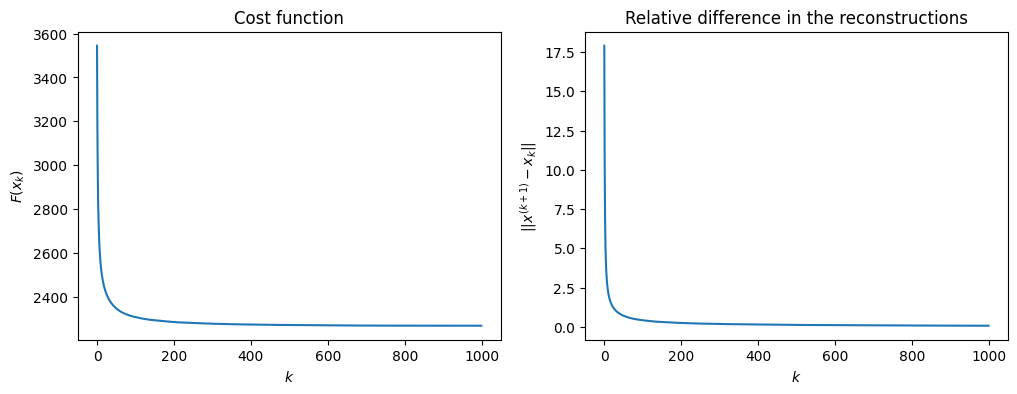

\lambda=0.5
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


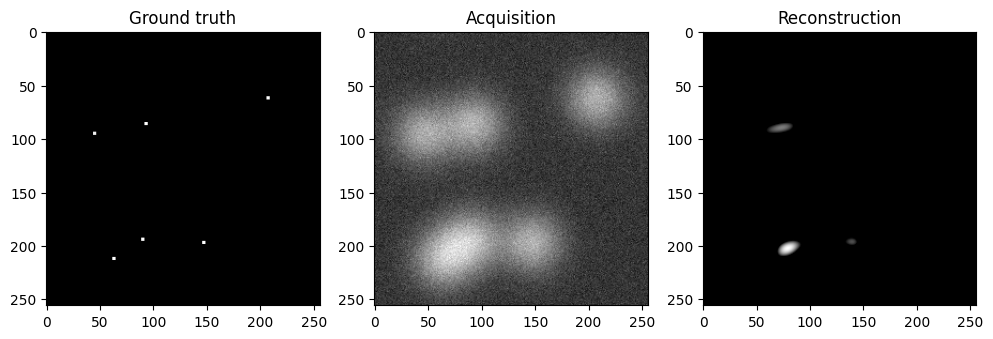

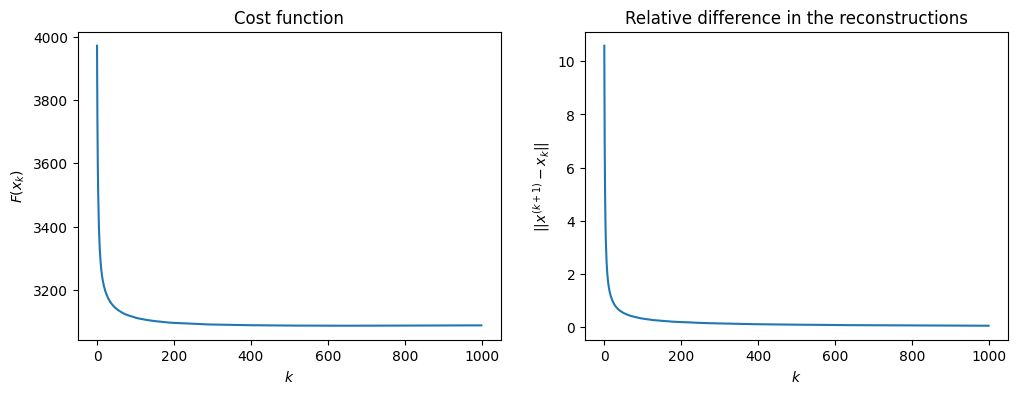

\lambda=0.6
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


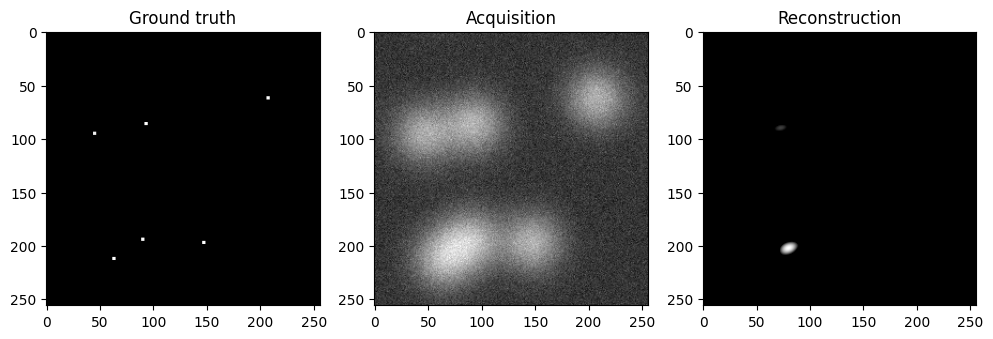

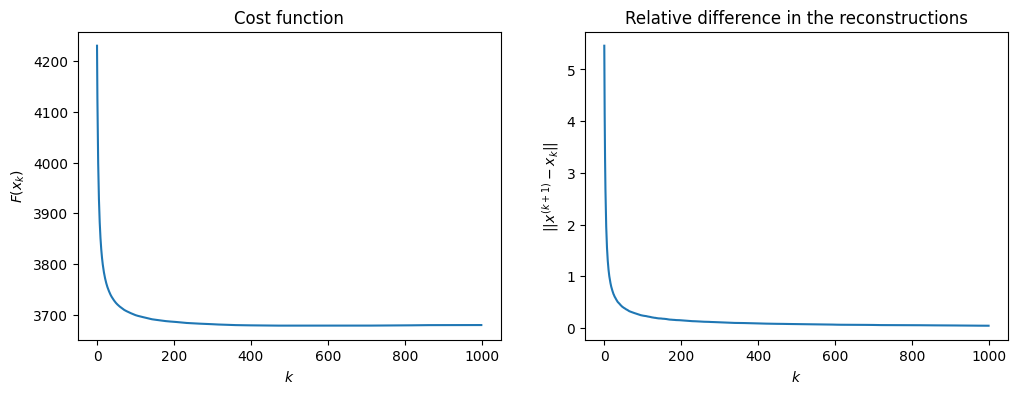

\lambda=0.7
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


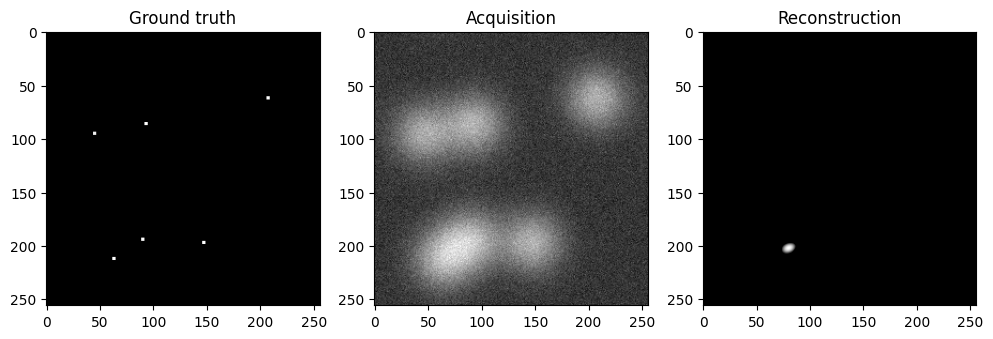

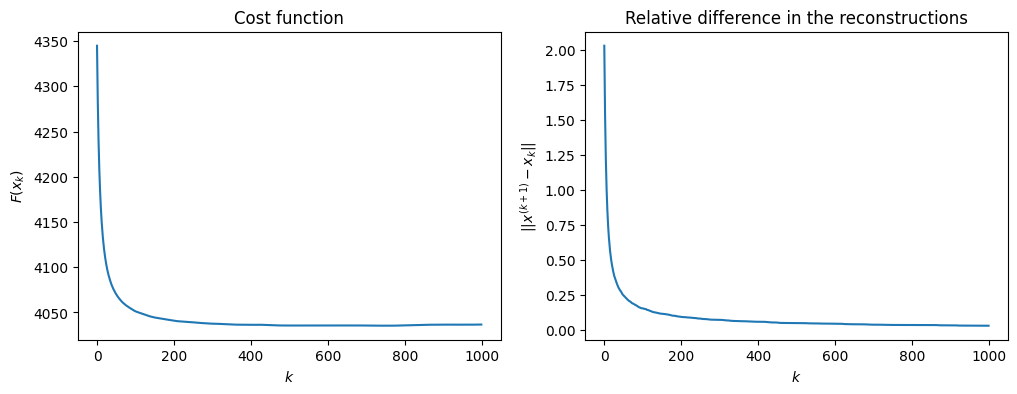

\lambda=0.8
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


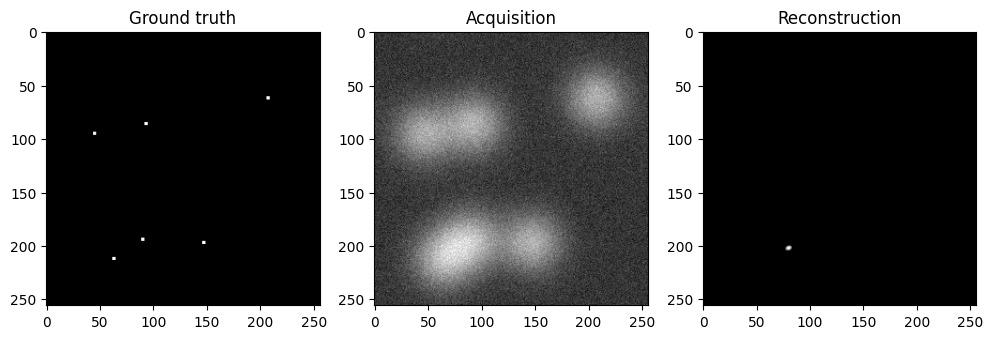

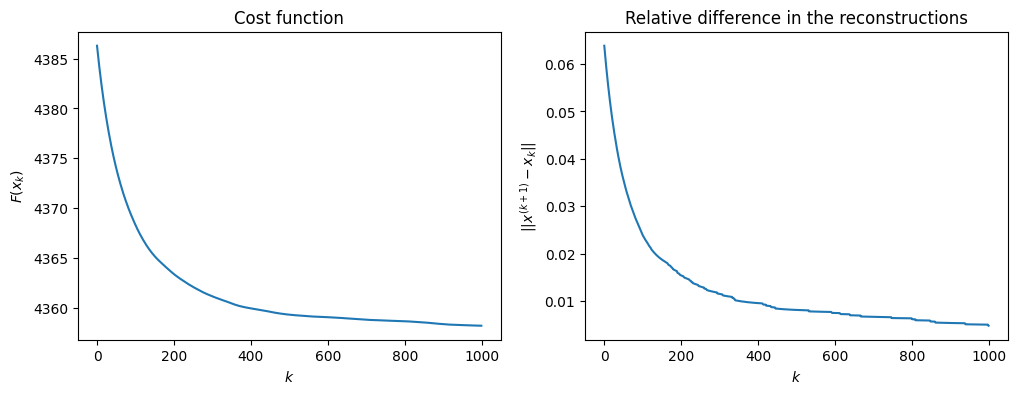

\lambda=0.9
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


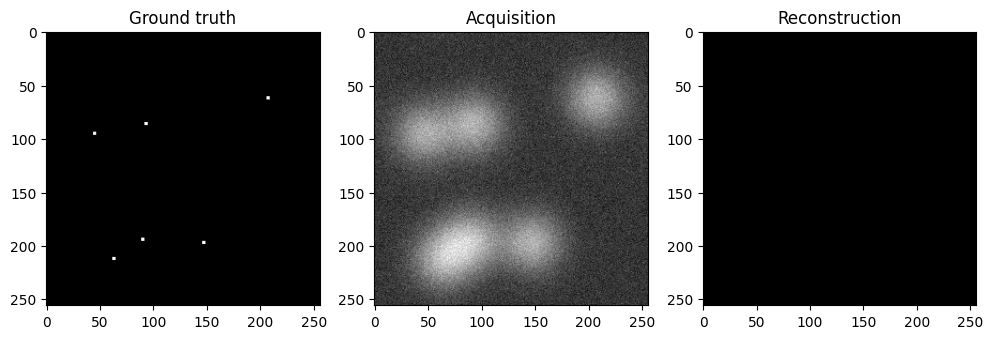

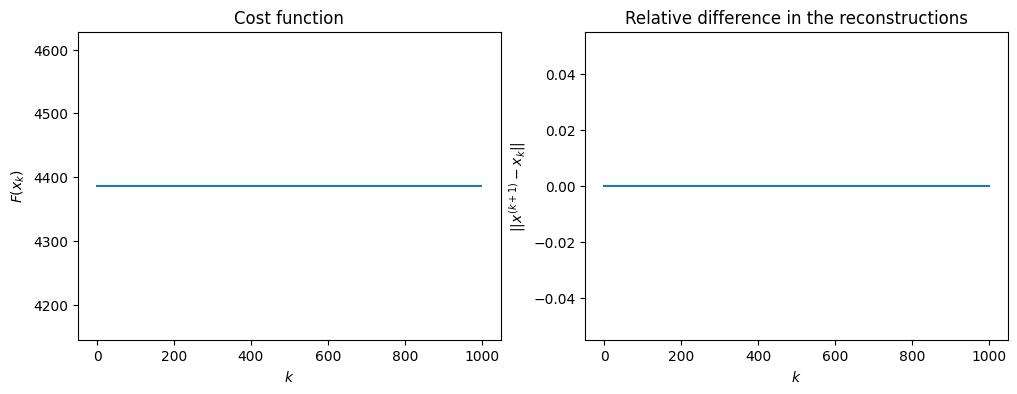

\lambda=1
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


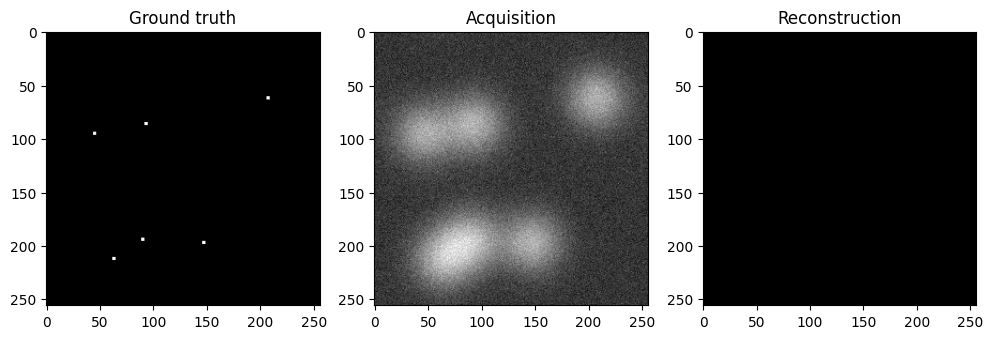

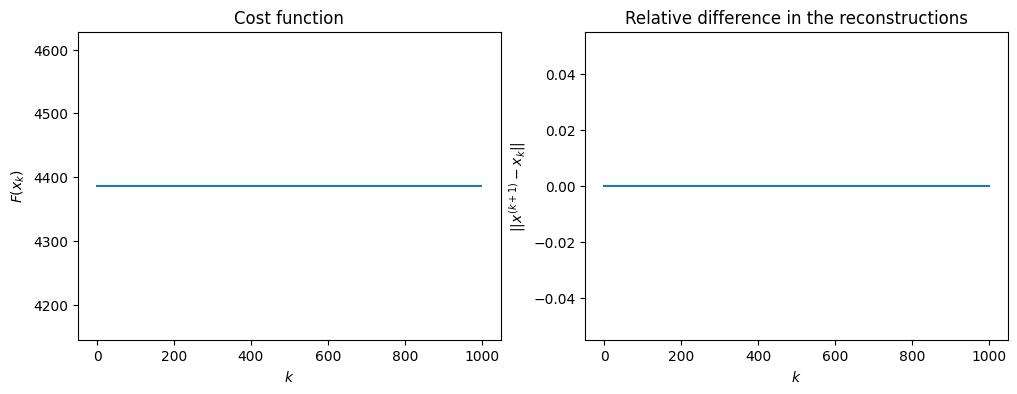

In [15]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 1
maxiter = 1000
epsilon = 0

# choose some values for lmbda
lmbda = [0.001, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7,0.8, 0.9, 1 ]

# compute the reconstruction
for l in lmbda:
    print(f'\lambda={l}')
    rec, cost, norms = FB(x0, tau, l, acq, h, epsilon, maxiter)
    plot_results(rec, cost, norms)

The regularization parameter plays a crucial role in image reconstruction. A small value leads to minimal regularization, often resulting in a reconstructed image that deviates significantly from the ground truth. Conversely, a large value introduces excessive regularization, essentially producing a blank image. Therefore, it's important to select a parameter that strikes a balance, avoiding both excessive blurring and missing information. However, finding the right parameter can be a tedious task, usually requiring grid-search techniques. Additionally, it's important to remember that what works well for one image might not be suitable for another, so each case needs to be evaluated independently.



2) For example try $\lambda=0$. What happens? Which algorithm are you actually using in this very particular case? (Look both at the reconstructed image and at the equation defining the model with $\lambda=0$)

Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


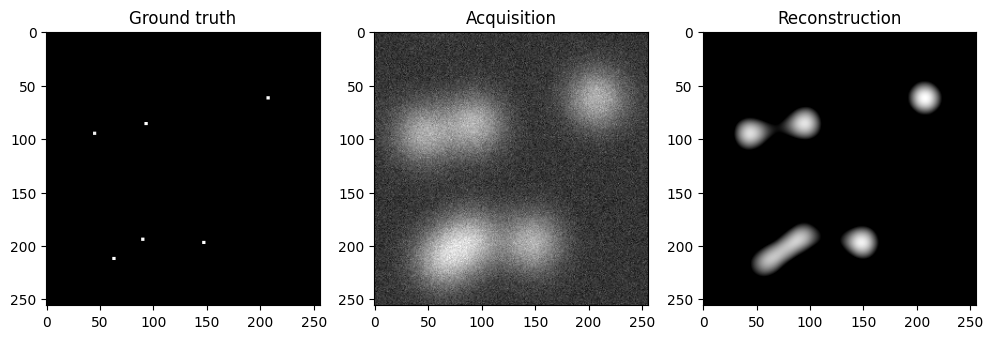

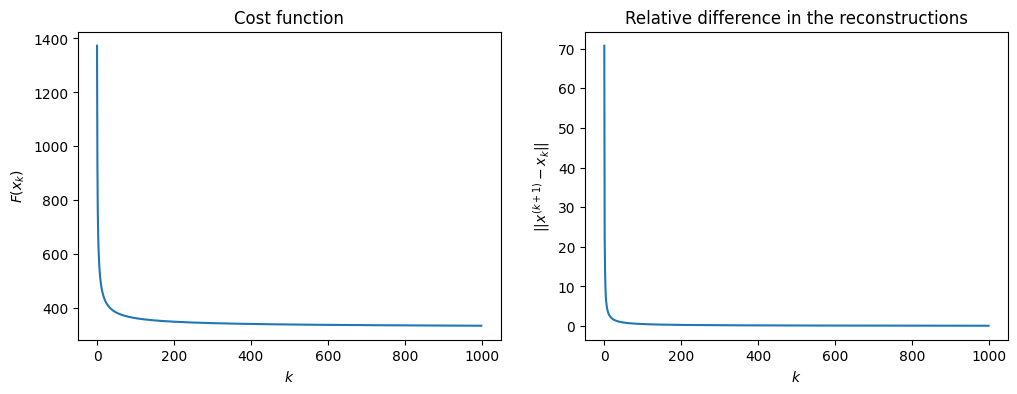

In [16]:
rec, cost, norms = FB(x0, tau, 0, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)

When we set $\lambda$ to zero, we effectively remove any regularization term, resulting in a reconstruction akin to those obtained with very small $\lambda$ values, which tend to yield poor results.


$$ \operatorname{argmin}_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|\_2^2+\lambda \|x\|\_1+\texttt{i}_{\ge 0}(x) \qquad (1)$$
with $\lambda=0$ becomes 
$$ \operatorname{argmin}_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|\_2^2+\texttt{i}_{\ge 0}(x) \qquad (2).$$


The optimization problem described by Equation (1) can be simplified when $\lambda=0$, leading to Equation (2). In this scenario, we aim to minimize the fidelity term without any penalty term.

To tackle Equation (1), we employ the Iterative Shrinkage-Thresholding Algorithm (ISTA), which involves three key steps: gradient descent for the fidelity term, a proximal step for the penalty, and projection onto the positive axes.

However, when dealing with Equation (2), the proximal step for the penalty vanishes due to the absence of the regularization parameter ($\lambda=0$). Despite this, we still execute the gradient step and the projection onto the positive axes.

The algorithm utilized in this specific case is referred to as Projected Gradient Descent.

## Questions: step-size
To answer the following questions set $\lambda=0.3$, $maxiter = 1000$, $\epsilon = 0$ and $x_0=0$.

3) Try a very small stepsize and observe how the cost function decreases.

Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


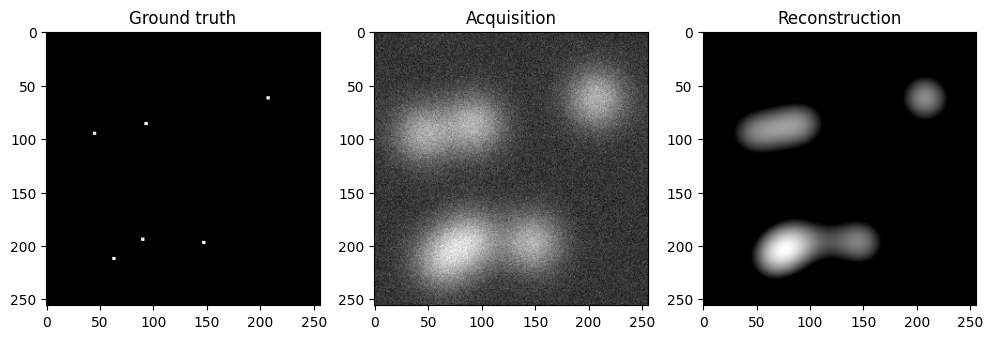

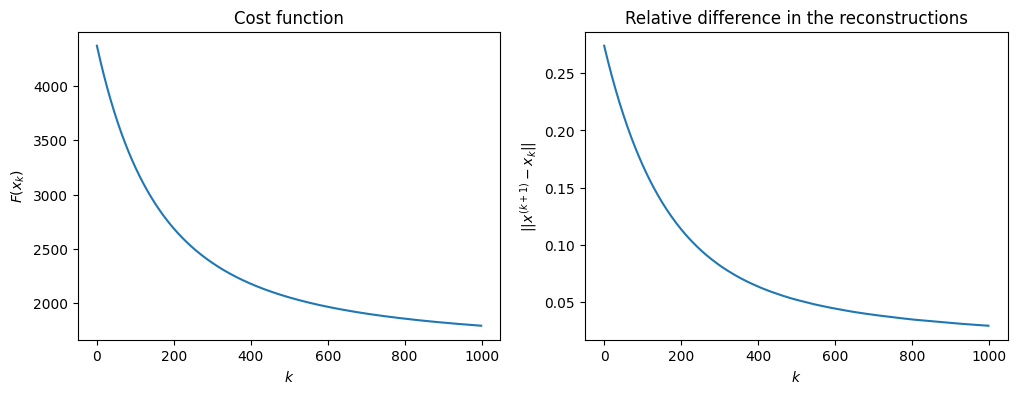

In [17]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 0.01
maxiter = 1000
epsilon = 0
lmbda = 0.3

rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)

4) Then try $\tau=\frac{1}{Lips}$. What do you observe? 

Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


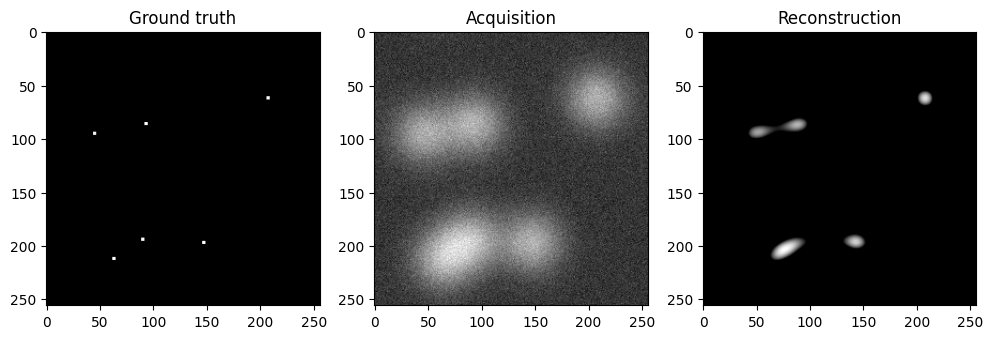

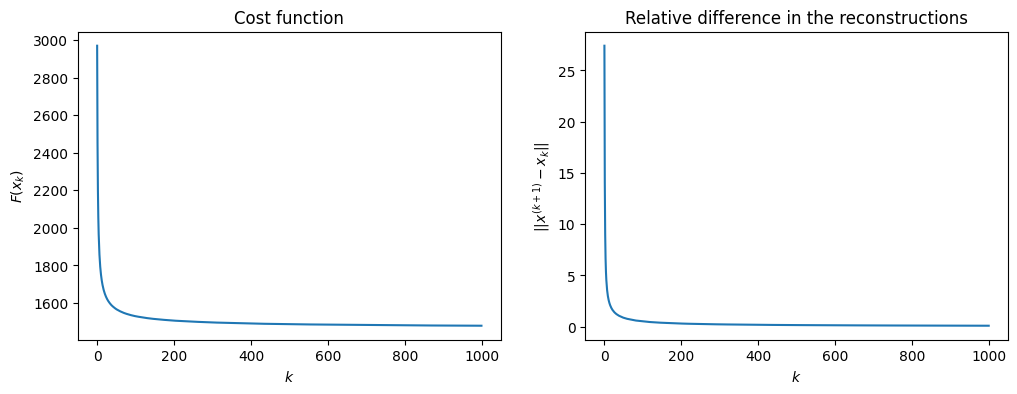

In [18]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 1/Lips
maxiter = 1000
epsilon = 0
lmbda = 0.3

rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)

5) Then try $\tau>>\frac{1}{Lips}$. What do you observe? 

(Hint: plot the cost functions in the three cases)

Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


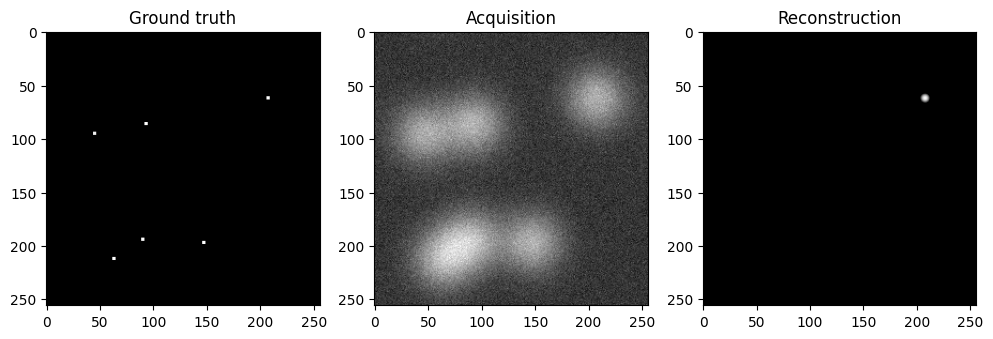

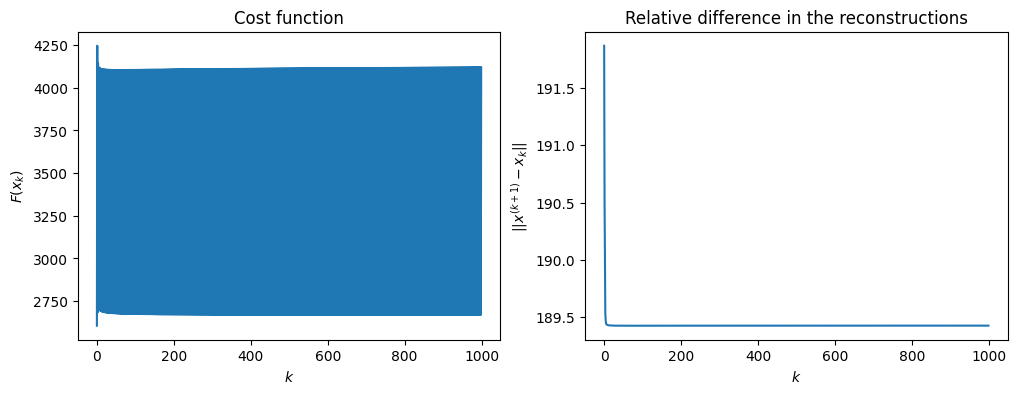

In [19]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 7
maxiter = 1000
epsilon = 0
lmbda = 0.3

rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)

Using a very small step size, denoted as $\tau$, slows down the convergence rate noticeably. Consequently, even after 1000 iterations, the resulting reconstruction remains heavily blurred. While it's still possible to achieve convergence and a satisfactory reconstruction, it requires a significantly higher number of iterations.

Setting $\tau=1/\text{Lips}$ is considered optimal. This choice significantly speeds up convergence compared to previous observations. Consequently, it's feasible to reach convergence and a satisfactory reconstruction in fewer than 1000 iterations, as the cost function experiences minimal decrease in the later stages.

However, if $\tau$ greatly exceeds $1/\text{Lips}$, the cost function fails to exhibit a decreasing trend and instead oscillates. This suggests that the step size is too large, causing the algorithm to oscillate across the breadth of the convex function during each iteration, hindering progress toward the minimum.

It's essential to note that convergence guarantees apply to $\tau$ values within the range of $(0, 1/\text{Lips}]$.

## Towards more complex regularisation functions
We now consider the following optimisation problem $$ \min_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|_2^2+\lambda\mathcal{R}_{\alpha,\beta}(x)+\texttt{i}_{\ge 0}(x) $$
where $$\mathcal{R}_{\alpha,\beta}(x) = \|x\|_1+\langle\alpha,x\rangle+\beta, \qquad \alpha\in\mathbb{R}^n, \beta>0$$
* Complete the functions below

In [20]:
def new_prox(x, tau, alpha, beta):
    """
    prox operator of R(x)
    """
    return np.sign(x-tau*alpha) * np.maximum(0, np.abs(x-tau*alpha) - tau)

def new_cost_function(x, h, y, lmbda, alpha, beta):
    fidelity_term = fidelity(x,h,y)
    return fidelity_term + lmbda * (np.linalg.norm(x, 1) + np.sum(alpha@ x) + beta)

In [21]:
# prox of \ell_1 norm: soft thresholding function
def soft_thresholding(x, gamma):
    return np.sign(x) * np.maximum(0, np.abs(x) - gamma)

* Modify the FB function accordingly

In [22]:
def FB(x0, tau, lmbda, y, h, epsilon, maxiter,alpha,beta):
    xk = x0
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)

    for k in np.arange(maxiter):

        if (k + 1) % 100 == 0:
            print(f'Iter {k+1}/{maxiter}')
        # forward step: gradient descent of f
        #xkk = (xk - tau*alpha) - tau* gradient(xk, h, y)
        xkk = xk - tau * gradient(xk, h, y)

        # backward step
        xkk = new_prox(xkk, lmbda * tau, alpha, beta)

        # positivity constraints
        xkk = np.maximum(0, xkk)

        # compute the cost function
        cost[k] = new_cost_function(xkk, h, y, lmbda,alpha,beta)
        norms[k] = np.linalg.norm(xkk-xk, 'fro')

        # update the iteration
        xk = xkk
        if np.abs(cost[k] - cost[k-1]) / cost[k] < epsilon:
            break
    return xk , cost, norms

* Test the new FB function using the following parameters and interpret the output.

Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


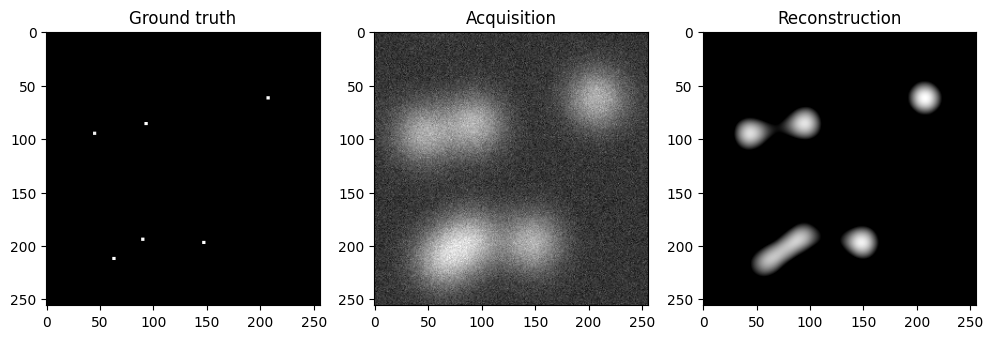

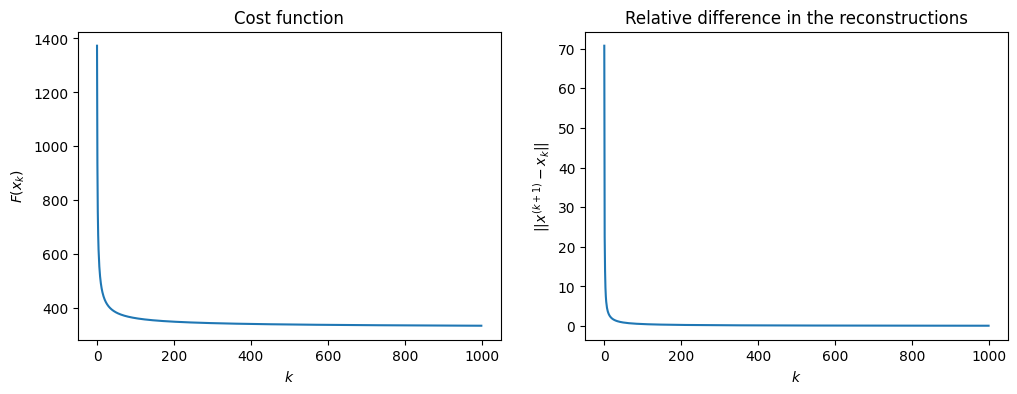

In [23]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 1/Lips
lmbda = 0.0000001
maxiter = 1000
epsilon = 0.000001
alpha = np.random.randn(*dim)
beta = 7*np.pi
#beta = 100000


rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter, alpha, beta)
plot_results(rec, cost, norms)

In this example, is the best reconstuctions I have, the cost function is decressing. The problem is that the recontructed image is not clear very good

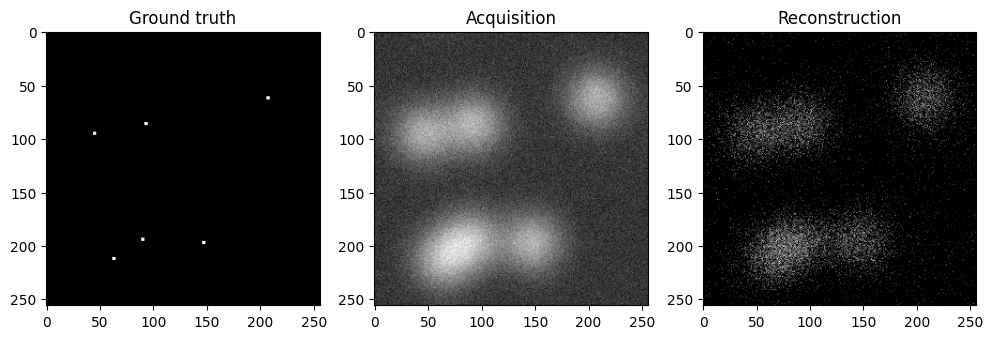

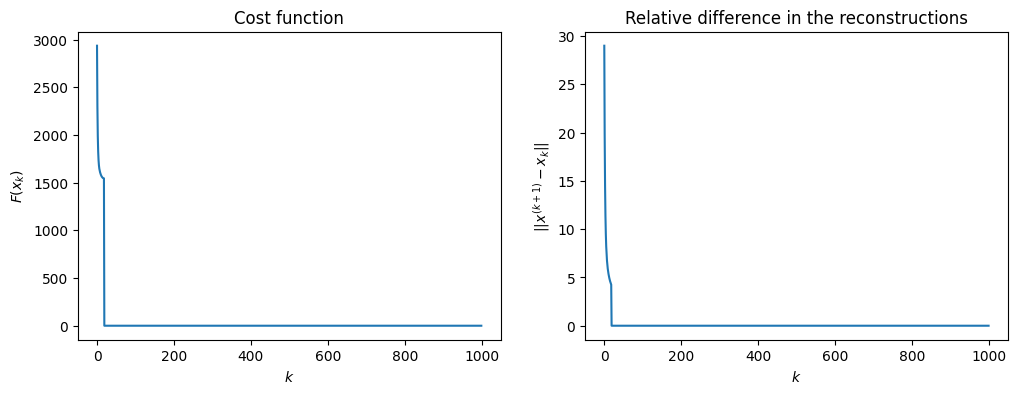

In [25]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 0.5
lmbda = 0.09
maxiter = 1000
epsilon = 0.001
alpha = np.random.randn(*dim)
beta = 7*np.pi


rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter, alpha, beta)
plot_results(rec, cost, norms)

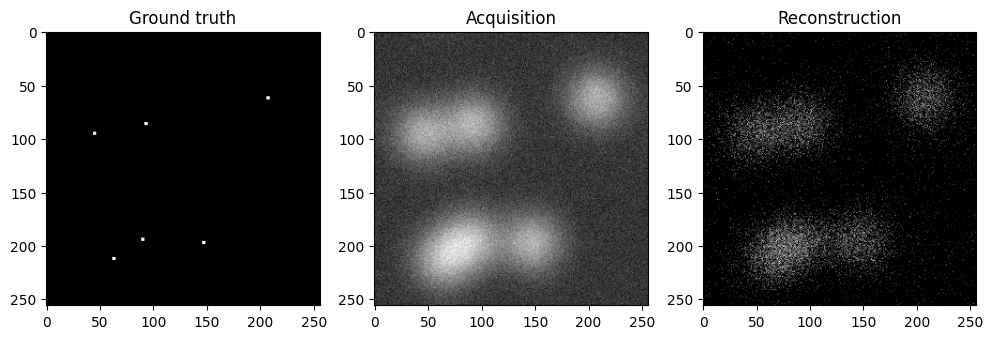

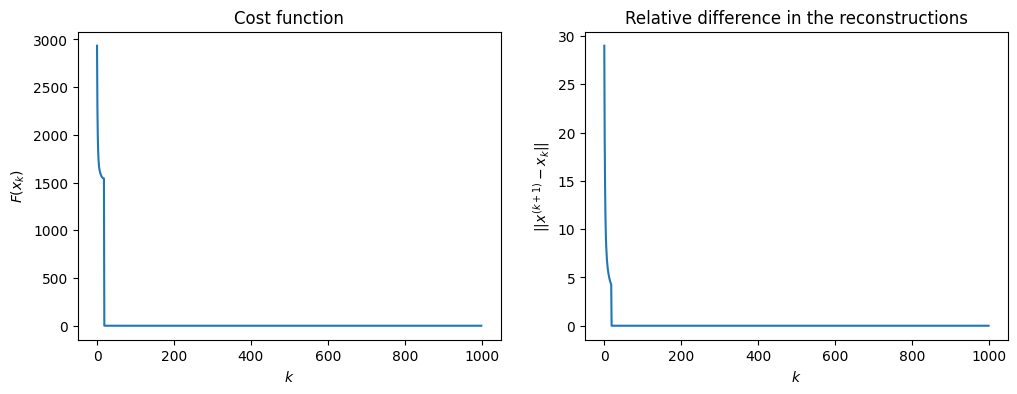

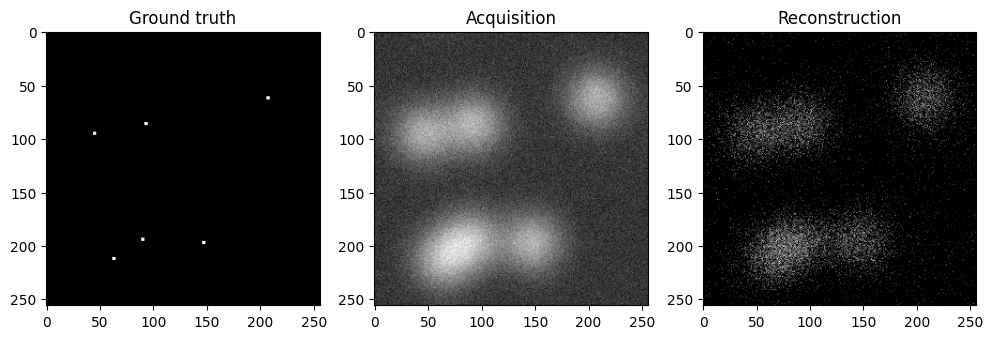

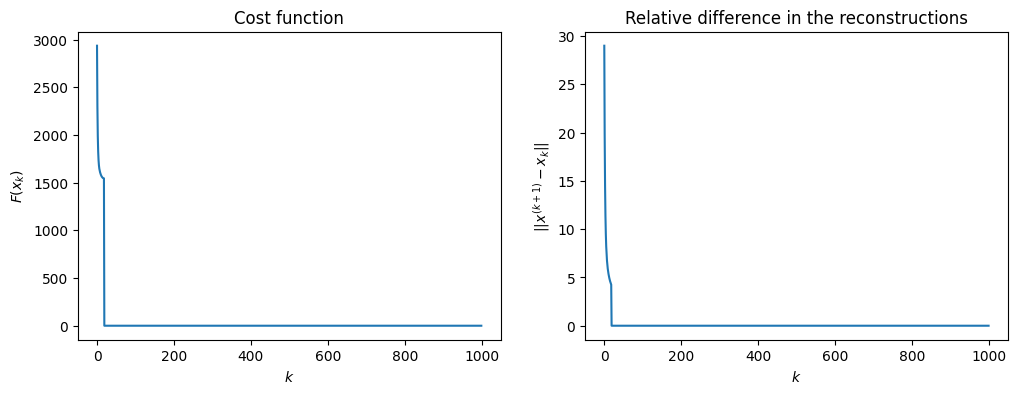

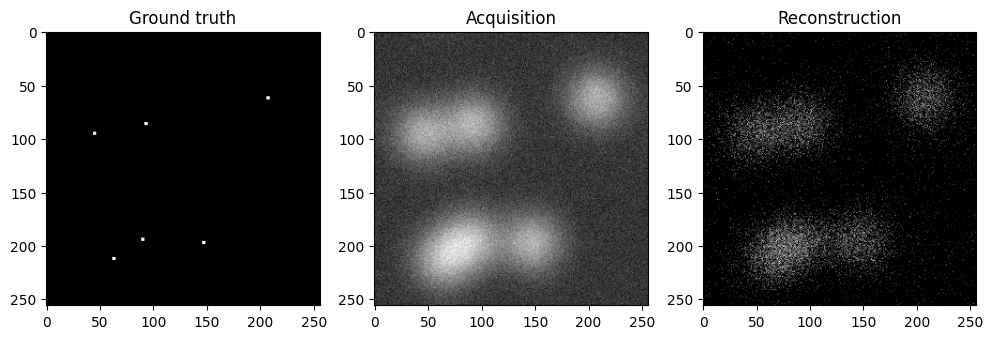

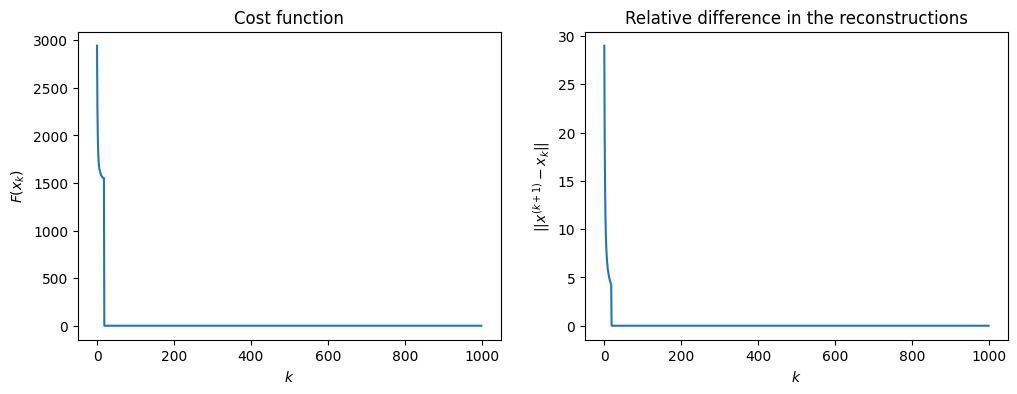

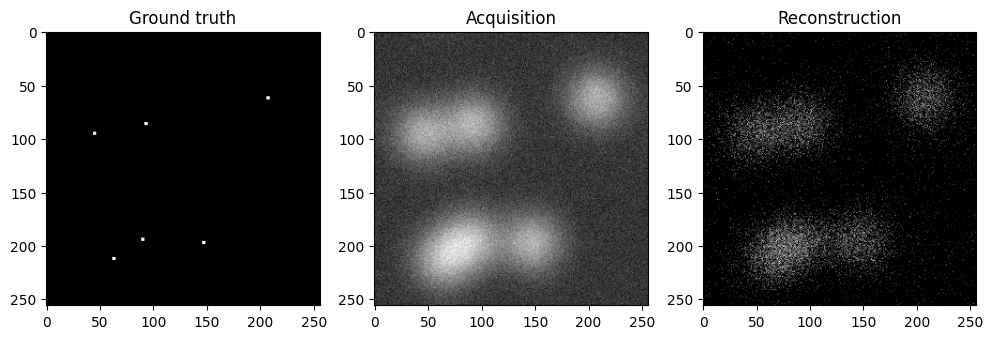

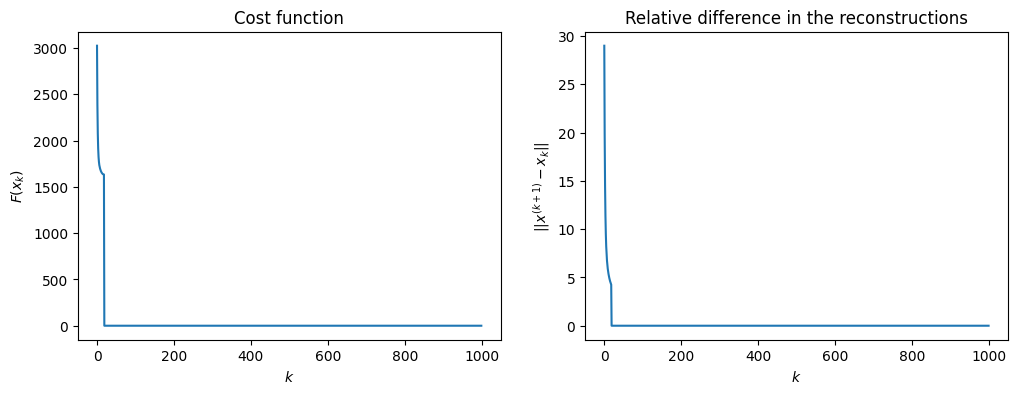

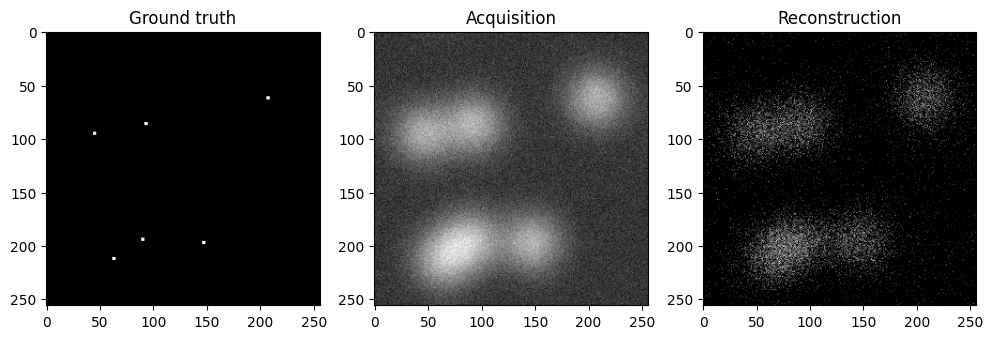

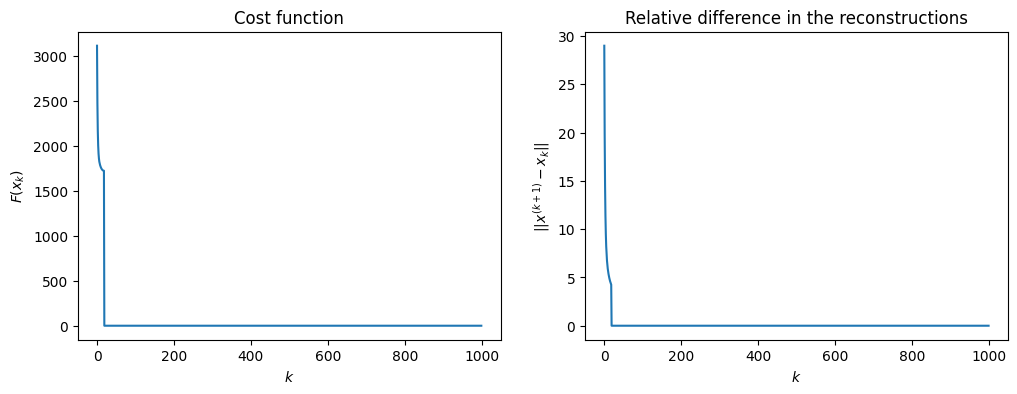

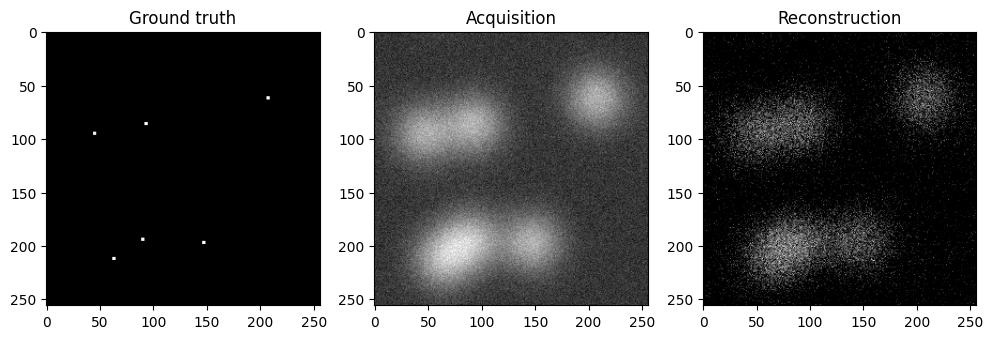

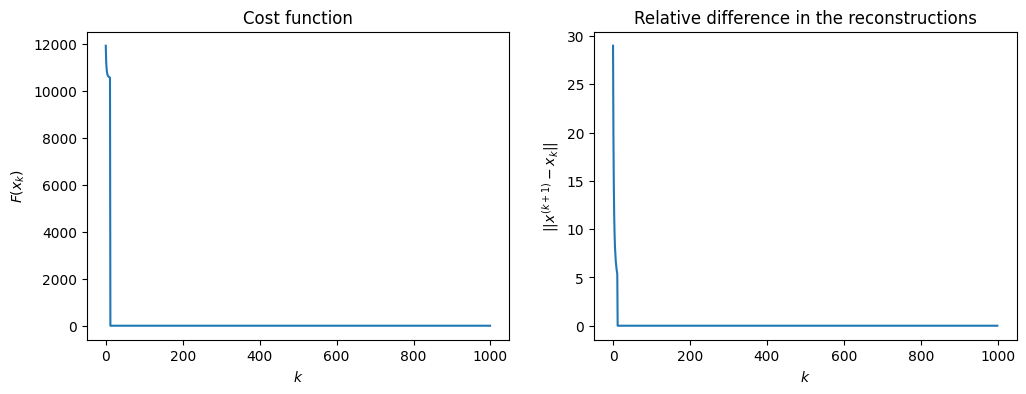

In [28]:
beta_list = [0, 7*np.pi, 100, 1000, 2000, 100000]
for beta in beta_list:
    rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter, alpha, beta)
    plot_results(rec, cost, norms)

* What is the impact of $\beta$ on the reconstruction?

From what I can see the impact of beta is very low, for different beta the reconstuction dosen't change to much.